In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import ERFutils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Select experiments and convolve to evaluate performance 
This notebook evaluates the performance of a given Green's function against the CMIP6 ensemble mean in terms of RMSE, MAE, bias, and relative bias. Individual plots can be turned off and/or modified within ERFutils.evalGF().

Loading 1pctCO2 experiment as training data...
	Loading 1pctCO2 experiment for convolution...
Convolving mean GF for Global Mean
Convolving mean GF Spatially

Results are shown in the following order:
['1pctCO2']

Mid-Century Stats:
RMSE: [0.187]
MAE: [0.133]
Bias: [0.0109]
Relative Bias: [1.1554]

End-of-Century Stats:
RMSE: [0.1885]
MAE: [0.1378]
Bias: [-0.0081]
Relative Bias: [-0.0429]


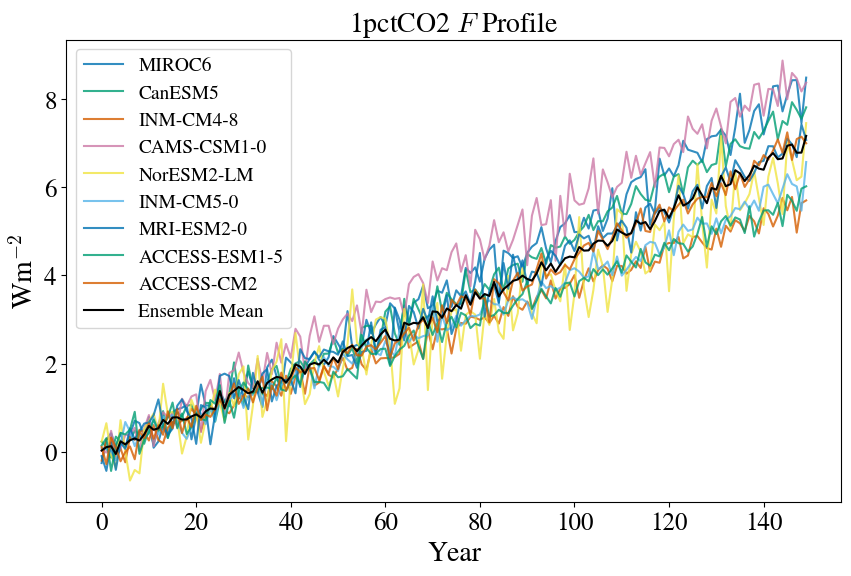

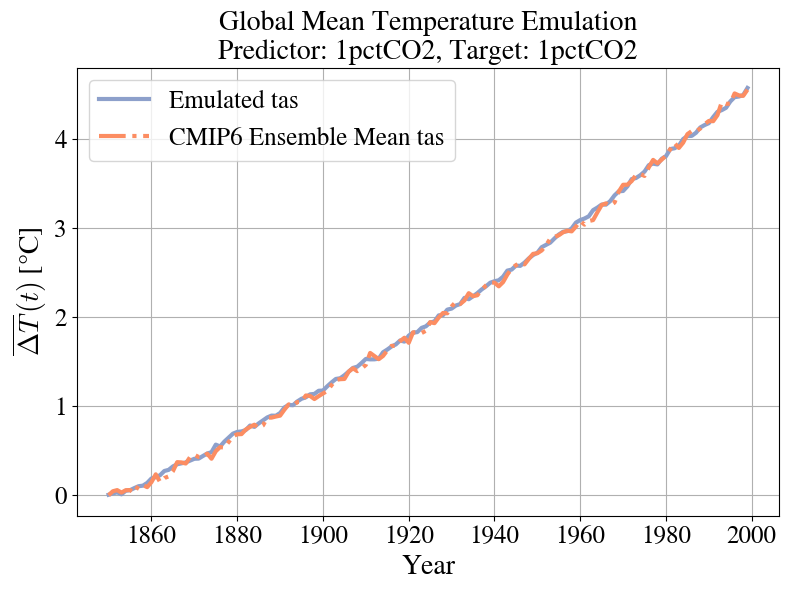

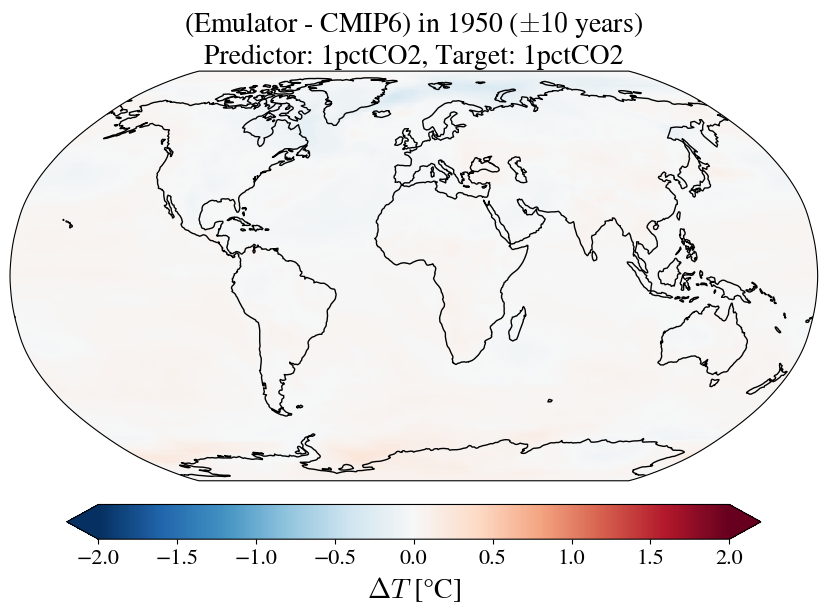

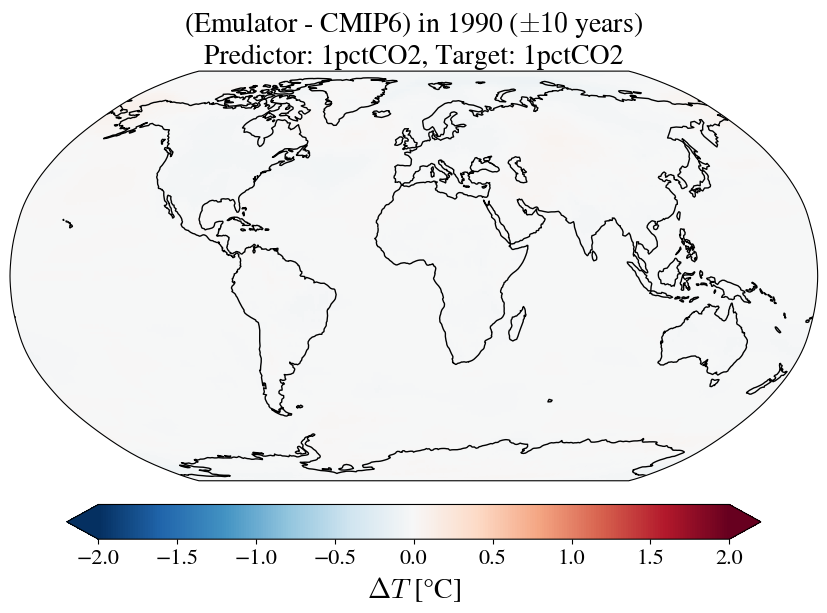

In [6]:
# Specify if we want to plot and/or save results
plot = True
save_result = False
save_fig = False

# Select experiment used for training
train_id = '1pctCO2'
print(f'Loading {train_id} experiment as training data...')

# Select experiments to convolve with for evaluation
conv_all = ['1pctCO2']#,'ssp126','ssp245','ssp370','ssp585']

# Evaluate experiments and record error statistics
(RMSE_short, RMSE_long, MAE_short, MAE_long,
 bias_short, bias_long, rel_bias_short, rel_bias_long) = ERFutils.eval_GF(train_id, conv_all, plot, save_result, save_fig)